# Logistic Regression with UCI Dataset

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import itertools
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

from ld import LD, BP, get_eta

In [2]:
def block_B(start_idx, end_idx):
    """
    Create a block B of indexes for the center region.

    Parameters:
    - start_idx: tuple or list, starting indices for each dimension
    - end_idx: tuple or list, ending indices for each dimension

    Returns:
    - center_region_indexes: numpy array with shape (n, d), the indexes of the center region, where d is the number of dimensions
    """
    if len(start_idx) != len(end_idx):
        raise ValueError("start_idx and end_idx must have the same number of dimensions.")

    # Generate all combinations of indices
    grids = [np.arange(start, end) for start, end in zip(start_idx, end_idx)]
    mesh_grids = np.meshgrid(*grids, indexing='ij')
    center_region_indexes = np.column_stack([grid.flatten() for grid in mesh_grids])

    return center_region_indexes

In [3]:
def compute_Q(theta):
        r"""Compute decomposable tensor Q from parameter \theta using Dynamic Programming.

        Parameters
        ----------
        theta : array
            second/third-order tensor.
            Same shapes as input tensor P.

        beta : list
            sets of decomposition basis vectors.

        Returns
        -------
        Q : array
            second/third-order tensor.
            Decomposable tensor.
        """
        idx = theta.shape
        order = len(theta.shape)
        theta_sum = np.zeros(theta.shape)

        if order == 2:
            theta_sum[0, 0] = theta[0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0] = theta[i, 0] + theta_sum[i-1, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j] = theta[0, j] + theta_sum[0, j-1]

            # update internal eta.
            for i in range(1, idx[0]):
                for j in range(1, idx[1]):
                    theta_sum[i, j] = theta[i, j] + theta_sum[i-1, j] \
                                        + theta_sum[i, j-1] - theta_sum[i-1, j-1]

        elif order == 3:
            theta_sum[0, 0, 0] = theta[0, 0, 0]

            # update outside eta.
            for i in range(1, idx[0]):
                theta_sum[i, 0, 0] = theta[i, 0, 0] + theta_sum[i-1, 0, 0]
            for j in range(1, idx[1]):
                theta_sum[0, j, 0] = theta[0, j, 0] + theta_sum[0, j-1, 0]
            for k in range(1, idx[2]):
                theta_sum[0, 0, k] = theta[0, 0, k] + theta_sum[0, 0, k-1]

            # update internal eta.
            for i, j in itertools.product(range(1, idx[0]), range(1, idx[1])):
                theta_sum[i, j, 0] = theta[i, j, 0] + theta_sum[i-1, j, 0] \
                                        + theta_sum[i, j-1, 0] - theta_sum[i-1, j-1, 0]
            for j, k in itertools.product(range(1, idx[1]), range(1, idx[2])):
                theta_sum[0, j, k] = theta[0, j, k] + theta_sum[0, j-1, k] \
                                        + theta_sum[0, j, k-1] - theta_sum[0, j-1, k-1]
            for i, k in itertools.product(range(1, idx[0]), range(1, idx[2])):
                theta_sum[i, 0, k] = theta[i, 0, k] + theta_sum[i-1, 0, k] \
                                        + theta_sum[i, 0, k-1] - theta_sum[i-1, 0, k-1]

            for i, j, k in itertools.product(range(1, idx[0]), range(1, idx[1]), range(1, idx[2])):
                theta_sum[i, j, k] = theta[i, j, k] + theta_sum[i-1, j, k] + theta_sum[i, j-1, k] \
                                    + theta_sum[i, j, k-1] - theta_sum[i-1, j-1, k] - theta_sum[i-1, j, k-1] \
                                    - theta_sum[i, j-1, k-1] + theta_sum[i-1, j-1, k-1]

        else:
            raise NotImplementedError("Order of input tensor should be 2 or 3. Order: {}.".format(order))

        Q = np.exp(theta_sum)
        psi = Q.sum()
        Q /= psi

        return Q

In [4]:
def find_factorization(D):
    factors = []

    # Try to find a factorization with 3 factors first
    for a in range(2, int(D**(1/3)) + 2):
        if D % a == 0:
            bc = D // a
            for b in range(a, int(bc**(1/2)) + 2):
                if bc % b == 0:
                    c = bc // b
                    factors.append((a, b, c))
                    return factors

    # If 3-factor factorization is not found, try 2-factor factorization
    for a in range(2, int(D**(1/2)) + 2):
        if D % a == 0:
            b = D // a
            factors.append((a, b))
            return factors

    return factors

## Basic Logistic Regression

In [5]:
UCI_id = 17
test_size = 0.5

In [6]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Normalize the input data
# X_mean = np.mean(X, axis=0)
# X_std = np.std(X, axis=0)
# X = normalization(X, X_mean, X_std)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = int(len(Y) * (1 - test_size))
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

print("Shape of features:", X_train.shape)

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

X_test_class = []
Y_test_class = []
for i in unique_labels:
    X_test_class.append(X_test[np.isin(Y_test, i).flatten()])
    Y_test_class.append(Y_test[np.isin(Y_test, i).flatten()])

Shape of features: (569, 30)
Shape of labels: (569,)
Unique labels: [0 1]
Shape of features: (284, 30)


In [7]:
# Feature dimension
D = X_train.shape[1]

D_ = find_factorization(D)[0]
print("Tensor Structure of the Feature:", D_)

D_ = [5, 6]
dim = len(D_)

Tensor Structure of the Feature: (2, 3, 5)


Accuracy on the test set: 0.9438596491228071


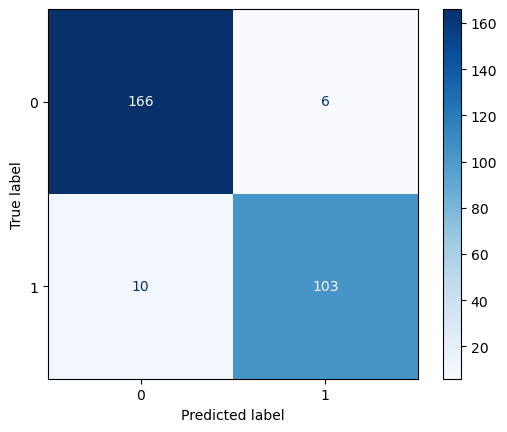

In [8]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, Y_train)

# Measure the accuracy on the test set
accuracy = clf.score(X_test, Y_test)
print("Accuracy on the test set:", accuracy)

# Optional: Display the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## Data Generation

### Legendre Decomposition

In [9]:
train_theta_class = []

for X_train_per_class in X_train_class:
    theta_list = []

    for x in X_train_per_class:
        x_tensor = x.reshape(*D_)
        _, scaleX, Q, theta = LD(x_tensor, order=2, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        theta_list.append(theta)

    train_theta_class.append(theta_list)

test_theta_class = []
for X_test_per_class in X_test_class:
    theta_list = []

    for x in X_test_per_class:
        x_tensor = x.reshape(*D_)
        _, scaleX, Q, theta = LD(x_tensor, order=2, verbose=False, n_iter=100, lr=1e-4, exit_abs=True)
        theta_list.append(theta)

    test_theta_class.append(theta_list)

theta_train = np.concatenate([np.array(theta).reshape(-1, D) for theta in train_theta_class])
theta_test = np.concatenate([np.array(theta).reshape(-1, D) for theta in test_theta_class])

### Classification on $\theta$'s

Accuracy on the test set: 0.6035087719298246


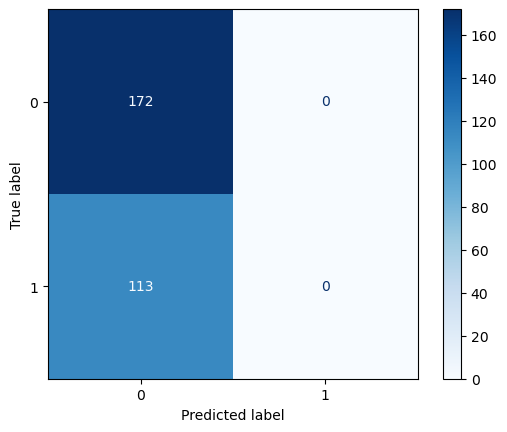

In [10]:
# Train a logistic classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(theta_train, Y_train)

# Measure the accuracy on the test set
accuracy = clf.score(theta_test, Y_test)
print("Accuracy on the test set:", accuracy)

y_pred = clf.predict(theta_test)
cm = confusion_matrix(Y_test, y_pred, labels=unique_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()